In [13]:
import pandas as pd
import numpy as np
import os
import time
import math
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import random
random.seed(10)
warnings.filterwarnings("ignore")
sns.set(style="white", color_codes=True)
%matplotlib inline

In [4]:
def readText(filename):
    f = open(filename, "r")
    return f.read()

def getDataFrame(data_dir):
    print('Preparing Pandas Dataframe')
    text_list=[]
    tag_list=[]

    for file_name in os.listdir(data_dir):
#        print(file_name)
        tag=file_name.split('_')[1].split('.')[0]
#        print(tag)
        tag_list.append(tag)
        text=readText(os.path.join(data_dir,file_name))
        text_list.append(text)
        
    data = {'text':text_list, 'tag':tag_list}         
    df = pd.DataFrame(data)
    
    return df

data_dir=r'Datasets\Question-6\dataset'  

df=getDataFrame(data_dir)
df.head(5)

Preparing Pandas Dataframe


text tag
0  Shares rise on new Man Utd offer\n\nShares in ...   1
1  Slater to star in Broadway play\n\nActor Chris...   2
2  Galloway plea for hostage release\n\nEx-Labour...   3
3  Connors boost for British tennis\n\nFormer wor...   4
4  Moving mobile improves golf swing\n\nA mobile ...   5

In [5]:
print("The data set contains {} records and {} features.".format(df.shape[0], df.shape[1]))

The data set contains 1725 records and 2 features.


In [6]:
df.tag.value_counts()

4    411
1    410
3    317
5    301
2    286
Name: tag, dtype: int64

Number of unqiue clsuters based on the tags provided

In [7]:
np.unique(df.tag)

array(['1', '2', '3', '4', '5'], dtype=object)

In [23]:
class KMeans:
    """The k-means algorithm."""

    def __init__(self, n_clusters):
        self.data = pd.DataFrame()
        self.n_clusters = n_clusters
        self.centroids = pd.DataFrame()
        self.clusters = np.ndarray(1)
        self.old_centroids = pd.DataFrame()
        self.verbose = False
        self.predictions = list()

    def train(self, df, verbose):
        self.verbose = verbose
        self.data = df.copy(deep=True)
        self.clusters = np.zeros(len(self.data))

        if 'species' in self.data.columns:
            self.data.drop('species', axis=1, inplace=True)

        # Randomly initialize centroids
        unique_rows = self.data.drop_duplicates()
        unique_rows.reset_index(drop=True, inplace=True)
        self.centroids = unique_rows.sample(n=self.n_clusters)
        self.centroids.reset_index(drop=True, inplace=True)

        if self.verbose:
            print("\nRandomly initiated centroids:")
            print(self.centroids)

        # Initialize old centroids as a matrix of all 0's
        self.old_centroids = pd.DataFrame(np.zeros(shape=(self.n_clusters, self.data.shape[1])),
                                          columns=self.data.columns)

        # Compare every data point in our dataset to each of the k-means and assign each point to closest cluster
        while not self.old_centroids.equals(self.centroids):
            
            if self.verbose:
                time.sleep(3)

            # Stash old centroids
            self.old_centroids = self.centroids.copy(deep=True)

            # Iterate through each data point in the matrix
            for row_i in range(0, len(self.data)):
                distances = list()
                point = self.data.iloc[row_i]

                # Calculate the distance between the current point and each of the centroids
                for row_c in range(0, len(self.centroids)):
                    centroid = self.centroids.iloc[row_c]
                    distances.append(np.linalg.norm(point - centroid))

                # Assign this data point to a cluster
                self.clusters[row_i] = np.argmin(distances)

            # For each cluster extract the values which now belong to each cluster and calculate new k-means
            for cls in range(0, self.n_clusters):

                cls_idx = np.where(self.clusters == cls)[0]

                if len(cls_idx) == 0:
                    self.centroids.loc[cls] = self.old_centroids.loc[cls]
                else:
                    # Set the new k-mean to the mean value of the data points within this cluster
                    self.centroids.loc[cls] = self.data.iloc[cls_idx].mean()
                    
                if self.verbose:
                    print("\nRow indices belonging to cluster {}: [n={}]".format(cls, len(cls_idx)))
                    print(cls_idx)

            if self.verbose:
                print("\nOld centroids:")
                print(self.old_centroids)
                print("New centroids:")
                print(self.centroids)

In [10]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',lowercase=True ,
                        ngram_range=(1, 2), stop_words='english')
X = tfidf.fit_transform(df.text).toarray()
y = df.tag    
enc = LabelEncoder()
y = enc.fit_transform(y)

In [11]:

print("Reducing the dimension "),
tic = time.time()
pca = PCA()
X_train_PCA_temp = pca.fit_transform(X)

toc = time.time()
print("Took: " + str(toc - tic) + " sec")

explained_variance = pca.explained_variance_ratio_
# Calculating optimal k components 
k = 0
total = np.sum(explained_variance)
current_sum = 0
while(current_sum / total < 0.99):
    current_sum += explained_variance[k]
    k += 1

## Applying PCA with k calcuated above
print("Reducing the dimension "),
tic = time.time()
pca = PCA(n_components=k, whiten=True)
X_train_PCA = pca.fit_transform(X)
toc = time.time()
print("Took: " + str(toc - tic) + " sec")

Reducing the dimension 
Took: 3.430126905441284 sec
Reducing the dimension 
Took: 3.223120927810669 sec


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_train_PCA,y,test_size=0.25, random_state=2489)    
    
print("Train data: ", X_train.shape)
print("Train labels: ", y_train.shape)
print("Test data: ", X_test.shape)
print("Test labels: ", y_test.shape)

Train data:  (1293, 1555)
Train labels:  (1293,)
Test data:  (432, 1555)
Test labels:  (432,)


In [21]:
X_train.shape

(1293, 1555)

In [25]:
df=pd.DataFrame(data=X_train)

In [26]:
# Run through a simple application
number_of_clusters = 5
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.train(df=df, verbose=False)

In [28]:
# Extract the results
df['cluster'] = kmeans.clusters
centroids = kmeans.centroids
centroids['cluster'] = 'centroid'
all_df = pd.concat([df, centroids])

In [36]:
from sklearn.cluster import KMeans
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X_train) 
    kmeanModel.fit(X)           
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 

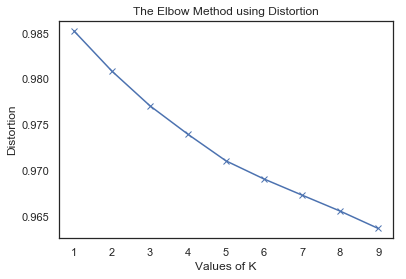

In [37]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 